-----------
## In this notebook:
* Create a model using precip vs no precip images
* Model should determine which images contain precipitation
-----------

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


#import warnings
#warnings.filterwarnings("ignore")

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
# define path where images are located
PATH = '/tf/kokamura/Precip/3st-2cl'
data_dir = pathlib.Path(PATH)

# list containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

# set batch size and original image dimensions
batch_size = 80
img_height = 720
img_width = 1280

# total image count
print(image_count)

59207


In [ ]:
# do a quick check and make sure you have image data
files = os.listdir(f'{PATH}/WP')[:10]
img = plt.imread(f'{PATH}/WP/{files[9]}')
plt.imshow(img);
print(img.shape)
# First 4 rows and columns of the image
img[:4,:4]

In [5]:
# create training and validation generators

#reduce dimesionality

train_datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        )
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.2,
        )

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(180,320),
        batch_size=batch_size,
        subset='training',
        seed=123,
        class_mode='binary')
validation_generator = valid_datagen.flow_from_directory(
        data_dir,
        target_size=(180,320),
        batch_size=batch_size,
        subset='validation',
        seed=123,
        class_mode='binary')

Found 47366 images belonging to 2 classes.
Found 11841 images belonging to 2 classes.


In [6]:
# check classs names to make sure you dont have any hidden folders and img dims are correct
class_names = [key for key in train_generator.class_indices]
print(class_names)

['NP', 'WP']


In [ ]:
# display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(15, 15))
images, labels = next(iter(train_generator))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [16]:
# referenced pg 461 of textbook
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 320, 3)),  #rescale input in the [0, 255] range to be in the [0, 1] range
  layers.Conv2D(8, 3, padding='same', activation='elu'),
  layers.Conv2D(8, 3, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 5, padding='same', activation='elu'),
  layers.Conv2D(16, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='elu'),
  layers.Conv2D(32, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='elu'),
  layers.Conv2D(64, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='elu'),
  layers.Conv2D(128, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(100, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(50, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(10, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation='softmax')
])

In [17]:
opt = keras.optimizers.Adam(learning_rate=4e-3)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# view all the layers of the network using the model's summary method:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 320, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 180, 320, 8)       224       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 320, 8)       584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 160, 8)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 160, 16)       3216      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 90, 160, 16)       6416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 45, 80, 16)       

In [ ]:
epochs=10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1474s 2s/step - loss: 12.7779 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 2/10
592/592 [==============================] - 1444s 2s/step - loss: 0.8048 - accuracy: 0.4993 - val_loss: 0.6935 - val_accuracy: 0.4983
Epoch 3/10
240/592 [===========>..................] - ETA: 12:18 - loss: 0.7775 - accuracy: 0.4895

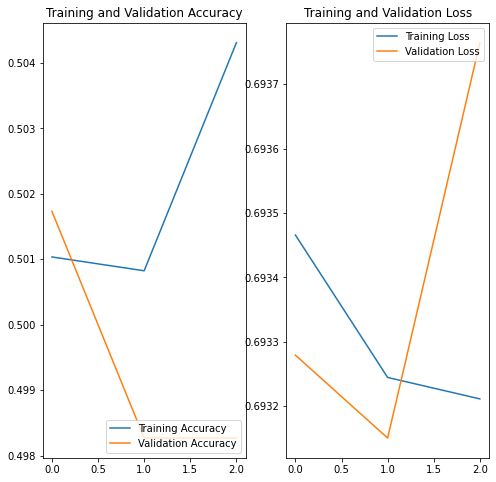

In [11]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.51591617 0.4840838 ]]
This image most likely belongs to NP with a 50.80 percent confidence.


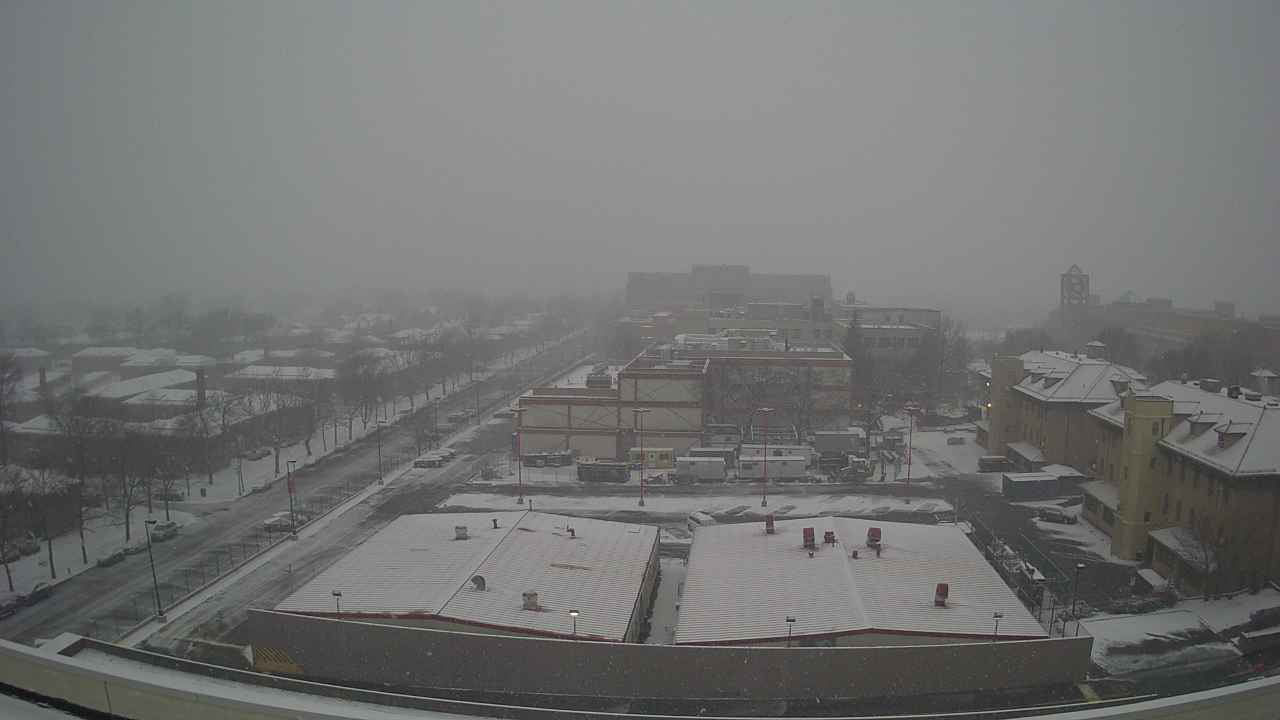

In [12]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [ ]:
epochs=100
more_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=5,
    validation_steps=5,
    epochs=epochs
    )

In [ ]:
acc = more_history.history['accuracy']
val_acc = more_history.history['val_accuracy']

loss = more_history.history['loss']
val_loss = more_history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)
